<a href="https://colab.research.google.com/github/vujjiniashrith/ESS-profit-maximaization-using-deep-Reinforcemetn-Learning/blob/main/DQN_openai_gym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gym
import random


In [ ]:
# !pip install seaborn

In [ ]:
# import tensorflow as tf

# # Force CPU-only execution (useful if you have GPU-related issues)
# tf.config.set_visible_devices([], 'GPU')

In [ ]:
from gym import Env
from gym import spaces
from gym.spaces import Discrete, Box


In [ ]:
data_elec = pd.read_csv("electicity_data_hourly.csv")
data_cons = pd.read_csv("consumer_data_hourly.csv")

In [ ]:
print(data_elec.columns)

Index(['datetime', 'system_energy_price_da'], dtype='object')


In [ ]:
print(data_cons.columns)

Index(['dateTime', 'use'], dtype='object')


In [ ]:
data_elec.head(6)

,datetime,system_energy_price_da
0,2022-01-01 00:00:00,21.02
1,2022-01-01 01:00:00,18.43
2,2022-01-01 02:00:00,18.11
3,2022-01-01 03:00:00,18.15
4,2022-01-01 04:00:00,17.70
5,2022-01-01 05:00:00,17.67


In [ ]:
data_elec.rename(columns={'system_energy_price_da':'price'},inplace = True)

In [ ]:
data_elec.head()

,datetime,price
0,2022-01-01 00:00:00,21.02
1,2022-01-01 01:00:00,18.43
2,2022-01-01 02:00:00,18.11
3,2022-01-01 03:00:00,18.15
4,2022-01-01 04:00:00,17.70


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
data_elec['price'] = scaler.fit_transform(data_elec[['price']])

In [ ]:
data_elec.head()

,datetime,price
0,2022-01-01 00:00:00,0.016487
1,2022-01-01 01:00:00,0.010621
2,2022-01-01 02:00:00,0.009897
3,2022-01-01 03:00:00,0.009987
4,2022-01-01 04:00:00,0.008968


In [ ]:
data_cons.rename(columns={'use':'usage'},inplace = True)

In [ ]:
data_cons.head()

,dateTime,usage
0,2016-01-01 00:00:00,2.108533
1,2016-01-01 01:00:00,1.852600
2,2016-01-01 02:00:00,1.988000
3,2016-01-01 03:00:00,1.993267
4,2016-01-01 04:00:00,1.781533


In [ ]:
print(data_cons.usage.max()," ",data_cons.usage.min())
print(data_elec.price.max()," ",data_elec.price.min())

29.8692   0.0
1.0   0.0


In [ ]:
print(data_cons.usage.median(), " ", data_cons.usage.mean())

3.519333333333332   5.361010481177898


In [ ]:
data_elec.shape

(8737, 2)

In [ ]:
data_cons.shape

(8784, 2)

In [ ]:
split_point = 7027
train_elec = data_elec[:split_point]
train_cons = data_cons[:split_point]
test_elec = data_elec[split_point:]
test_cons = data_cons[split_point:]
print(train_elec.shape, test_elec.shape)
print(train_cons.shape, test_cons.shape)

(7027, 2) (1710, 2)
(7027, 2) (1757, 2)


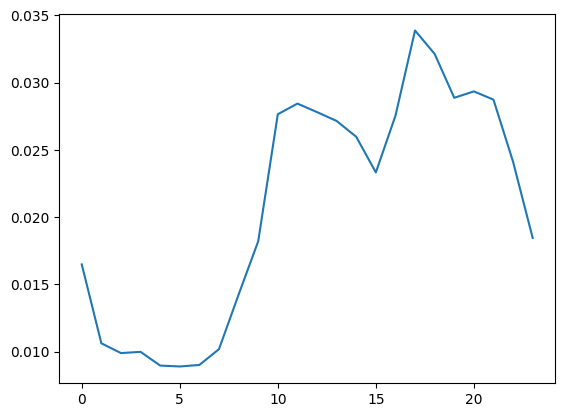

In [ ]:
plt.plot(data_elec.price[:24])

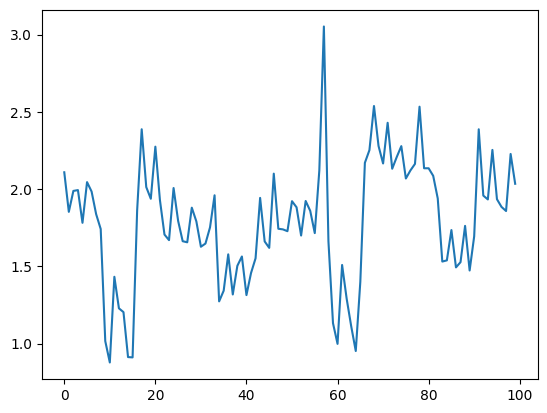

In [ ]:
plt.plot(data_cons.usage[0:100])

In [ ]:
data_usage = data_cons['usage'].values

In [ ]:
data_price = data_elec['price'].values

# Create Custom Environment of SmartGrid

In [ ]:
class SmartGrid(Env):
    def __init__(self,data_usage,data_price):
        #load electricity price data

        self.data_price = data_price

        #load consumer price data
        self.data_usage = data_usage

        #set maximum battery capacity
        self.max_capacity = 10

        #Actions that we can take
        #0 == -3, 1 == -2, 2 == -1, 3 ==0 , 4 == 1, 5 == 2, 6== 3 total 7 actions to take
        #-ve values stand for discharge and positive values stand for charge
        self.action_space = Discrete(7)

        #state
        self.observation_space = Box(low=np.array([0]), high=np.array([10]))

        #set initial start state
        self.state = 0

        #set initial position
        self.time_step = 0

        #initiate profits
        self.profits =0



        #current capacity
        self.current_capacity = []

        #action history
        self.action_history = []

        #profits history
        self.profits_history = []

        #rewards history
        self.reward_history = []


    def step(self,action):
        reward = 0

        reward = self.custom_reward(action)
        reward += self.punishment_for_bad_choices( action)

        self.reward_history.append(reward)
        self.action_history.append(action - 3)  # Store the action in action_history
        self.profits_history.append(self.profits)
        self.current_capacity.append(self.state);

        if self.time_step > 100:
            done = True
        else:
            done = False

        self.state += action - 3


        info = {}
        self.time_step += 1

        return self.state, reward, done, info

    def custom_reward(self,action):
        reward = 0

        # Calculate the change in profits due to the current action
        prev_profits = self.profits
        self.profits += (3 - action) * self.data_price[self.time_step]
        profit_change = self.profits - prev_profits

            # Define the reward based on the action type
        if action < 3:
            # rewarding for buying
            reward = -1 * profit_change*10
        elif action ==0:
            reward = 0
        else:
            # penalizing for selling
            reward = -1 * profit_change*2

        return -reward



    def punishment_for_bad_choices(self, action):
        punishment = 0

        #criteria for bad choices and assign a punishment
        if action == 1 or action == 0 or action == 2:
            if self.state < 3 - action:
                # Penalize actions that attempt to discharge more than available
                punishment = -5
        elif action == 4 or action == 5 or action == 6:
            if self.state > self.max_capacity - (action - 3):
                # Penalize actions that attempt to charge beyond capacity
                punishment = -5

        #punishment for storing the energy after horizon
#         if(self.time_step == 24):
#             if(self.state != 0):
#                 punishment = -10

        return punishment

    def render(self):
        #implement vizualization
        pass
    def reset(self):
        #reset the initial timestamp
        self.time_step =0
        self.profits = 0

        #empty the entire battery
        self.state = 0
        #set done state as false
        self.action_history = []
        self.profits_history = []
        self.reward_history = []
        self.current_capacity=[]

        return self.state
    def get_action_history(self):
        return self.action_history

    def get_time_step(self):
        return self.time_step
    def get_reward_history(self):
        return self.reward_history

    def get_profits_history(self):
        return self.profits_history
    def get_current_capacity(self):
        return self.current_capacity


In [ ]:
env = SmartGrid(data_usage,data_price)

In [ ]:
env.observation_space.sample()

array([8.157816], dtype=float32)

In [ ]:
print(env.observation_space.shape)

(1,)


In [ ]:
data_elec.price[:6].values

array([0.016487  , 0.01062143, 0.00989673, 0.00998732, 0.0089682 ,
       0.00890026])

In [ ]:
episodes = 10
for episode in range(1,episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:

        action = env.action_space.sample()
        n_state , reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode,score))
    action_history = env.get_action_history()
    print(action_history)
    #print(env.get_profits_history())
    print(env.get_reward_history())
    print(len(action_history),env.get_time_step())


Episode:1 Score:-167.81814475948906
[-2, 2, -2, 2, -2, -3, 3, 2, -1, -3, 0, -2, -1, 0, 2, -2, -2, 2, -1, -1, -2, 2, 1, 0, 0, -3, 3, -3, 2, 0, 3, 1, -1, 2, -1, 2, 3, 1, -3, -1, -3, 3, -1, -2, 0, 2, -2, 3, -1, -3, 1, 0, 1, -2, 0, -2, -2, 3, -3, 3, 2, 0, 0, 3, 3, 0, -3, -1, -3, -1, 2, 1, 2, 2, -3, 0, -2, 2, -2, -3, -3, 1, 0, 2, 2, 1, 3, 2, 1, 0, 0, -2, -1, 1, 3, 1, 2, -1, -2, -1, -3, 2]
[-4.670259987317692, -0.04248573240329741, -4.802065404475043, -0.039949270767279624, -4.820635927167316, -4.732992118851345, -0.05408098559652141, -0.04076456200742819, -4.8575505027629315, -4.453754869100462, 0.0, -4.431107890207446, -4.721895099193768, 0.0, -0.10390433916115593, -4.533472234803877, -4.449225473321859, -0.13551952169580578, -4.678639369508108, -4.711251019114051, -4.412990307093034, -0.11495606486094756, -0.04823806504212336, 0.0, 0.0, -4.525772261980252, -0.09348672887036868, -4.53800163058248, -0.05933508469970106, 0.0, -0.10191140501857054, -0.038228100371410445, -4.7651508288794275, 

# Creating Deep Learning Model with Keras

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
states = env.observation_space.shape
actions = env.action_space.n

In [ ]:
!

In [ ]:
del model

In [ ]:
print(states)
print(actions)

(1,)
7


In [ ]:
def build_model(states, actions):
    model = Sequential()

    model.add(Dense(24, activation='relu', input_shape=(1,)))  # Use input_shape as a tuple with a single integer
    model.add(Dense(64, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
model = build_model(states, actions)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 24)                48        
                                                                 
 dense_13 (Dense)            (None, 64)                1600      
                                                                 
 dense_14 (Dense)            (None, 24)                1560      
                                                                 
 dense_15 (Dense)            (None, 7)                 175       
                                                                 
Total params: 3,383
Trainable params: 3,383
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy

In [ ]:
def build_agent(model, actions):
    policy = EpsGreedyQPolicy(eps=0.2)
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-4,gamma = 0.99)
    return dqn

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-5), metrics=['mae'])
dqn.fit(env, nb_steps=100000, visualize=False, verbose=1)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 37s 4ms/step - reward: -0.7626
98 episodes - episode_reward: -77.821 [-383.338, 37.333] - loss: 7.501 - mae: 3.286 - mean_q: 5.985

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 37s 4ms/step - reward: 0.2502
98 episodes - episode_reward: 25.525 [-72.006, 48.003] - loss: 1.025 - mae: 1.632 - mean_q: 2.479

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 38s 4ms/step - reward: 0.2033
98 episodes - episode_reward: 20.735 [-58.089, 46.128] - loss: 0.679 - mae: 1.577 - mean_q: 2.567

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 39s 4ms/step - reward: 0.1636
98 episodes - episode_reward: 16.682 [-73.141, 46.647] - loss: 0.579 - mae: 2.082 - mean_q: 3.007

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 40s 4ms/step - reward: 0.3288
98 episodes - e

In [ ]:
print(env.get_action_history())

[2, 3, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2, 3, -2, 3, -2, -2]


In [ ]:
scores = dqn.test(env, nb_episodes=10, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 10 episodes ...
Episode 1: reward: 47.677, steps: 102
Episode 2: reward: 47.677, steps: 102
Episode 3: reward: 47.677, steps: 102
Episode 4: reward: 47.677, steps: 102
Episode 5: reward: 47.677, steps: 102
Episode 6: reward: 47.677, steps: 102
Episode 7: reward: 47.677, steps: 102
Episode 8: reward: 47.677, steps: 102
Episode 9: reward: 47.677, steps: 102
Episode 10: reward: 47.677, steps: 102
47.67678231723887


In [ ]:
print(env.get_profits_history())

[-0.03297400126823082, -0.06483830057070389, -0.09452848989944743, -0.07455385451580762, -0.10145846544071023, -0.0836579400307999, -0.06563094483195944, -0.09620436633753059, -0.06771446689011687, -0.12233897998007068, -0.06703505752332642, -0.010145846544071045, -0.09357731678594078, -0.039269861400489194, -0.11719811577135614, -0.07054533925174386, -0.015467886583929759, -0.1171075278557841, -0.05283540175740564, -0.1394600960231906, -0.08075912673249397, -0.023281094302020196, -0.09563819186520525, -0.05872361626958971, -0.11436724340972923, -0.08275206087507936, -0.051589817918289795, -0.09778965486004176, -0.06812211251019124, -0.11629223661563555, -0.08232176827611204, -0.04409366790470159, -0.11454841924087333, -0.05580215599239068, -0.1467071292689556, -0.0846997010598787, -0.023281094302020196, -0.11425400851526413, -0.05405833861762847, -0.14577860313434193, -0.06963946009602326, 0.045044841018208104, -0.11746987951807233, -0.009670259987317742, -0.16905969743636204, -0.0638

In [ ]:
print(env.get_reward_history())

[-0.06594800253646164, -0.06372859860494613, -0.059380378657487076, 0.19974635383639805, -0.05380922184980522, 0.17800525409910326, 0.18026995198840462, -0.06114684301114229, 0.28489899447413713, -0.10924902617990762, 0.5530392245674426, 0.5688921097925538, -0.16686294048373945, 0.5430745538545159, -0.1558565087417339, 0.46652776519612277, 0.550774526678141, -0.2032792825437087, 0.6427212609837846, -0.1732493885315699, 0.5870096929069663, 0.5747803243047377, -0.14471419512637013, 0.3691457559561554, -0.11128725428027904, 0.3161518253464987, 0.31162242956789565, -0.09239967388350394, 0.2966754234985053, -0.09634024821088863, 0.3397046833952351, 0.3822810037141045, -0.14090950267234348, 0.5874626324848266, -0.18180994655312982, 0.620074282090769, 0.6141860675785851, -0.18194582842648788, 0.6019566989763566, -0.18344052903342695, 0.7613914303831868, 1.1468430111423136, -0.3250294410725609, 1.0779961953075459, -0.3187788748980886, 1.0517256997916478, 1.0304375396322132, -0.2176827611196666

In [ ]:
print(env.get_current_capacity())

[0, 2, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7, 5, 8, 6, 9, 7]


In [ ]:
capacity_history = env.get_current_capacity()

In [ ]:
profit_history = env.get_profits_history()

In [ ]:
net_profit = profit_history[-1] + capacity_history[-1]*data_elec.price[100]

In [ ]:
net_profit

0.44673430564362687

In [ ]:
print(scaler.inverse_transform(net_profit.reshape(-1, 1)))

[[211.]]
